In [257]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error as MSE, mean_absolute_error as MAE
import random


In [258]:

# Фиксируем датчики случайных чисел
random.seed(42)
np.random.seed(42)

# Загружаем данные
df = pd.read_csv('data.csv')

# Разделяем ИСХОДНЫЕ ДАННЫЕ на тренировочную и тестовую выборки
df_train, df_test = train_test_split(df, train_size=0.75, random_state=42)

/var/folders/34/9lmn_1px5cs289tjl5rn7cs80000gn/T/ipykernel_1370/2594801504.py:6: DtypeWarning: Columns (33,37,38,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv')


In [259]:
df_kladr = pd.read_csv('kladr-2.csv')
df_kladr = df_kladr.sort_values("TYPE_NP")
df_kladr = df_kladr.drop_duplicates(keep='first', subset='NAME').sort_values('NAME')

In [260]:
alphabet = {}
for i, j in enumerate(["A", "B", "C", "D", "E", "F", "G", "H", "I", "K"]):
    alphabet[i] = j

In [261]:
df_kladr["OKRUG_CODE"] = df_kladr["OKRUG_CODE"].replace(alphabet)

In [262]:
df_kladr[df_kladr['NAME'] == "Москва"]

,Unnamed: 0,NAME,SOCR,CODE,INDEX,GNINMB,UNO,OCATD,STATUS,REGION,TYPE_NP,OKRUG_OCATD,OKRUG_CODE
242478,242478,Москва,г,7700000000000,NaN,7700.0,NaN,4.500000e+10,0,Москва,gor,4.0,H


In [263]:
df_kladr[df_kladr['NAME'] == "Минск"]

,Unnamed: 0,NAME,SOCR,CODE,INDEX,GNINMB,UNO,OCATD,STATUS,REGION,TYPE_NP,OKRUG_OCATD,OKRUG_CODE
39998,39998,Минск,д,2400900002200,NaN,2411.0,2408.0,4.210819e+09,0,Красноярский,sel,0.0,C


In [264]:
df_kladr.loc[39998, "SOCR"] = 'г'

In [265]:
df_train = df_train.merge(df_kladr[['NAME', 'REGION', 'TYPE_NP', 'OKRUG_OCATD', 'OKRUG_CODE']], left_on='ann_city', right_on='NAME', how='left').drop(columns=['NAME'])
df_train.rename(columns={'TYPE_NP': 'type_city',
                   'REGION': 'region',
                   'OKRUG_OCATD': 'okr_ocatd',
                   'OKRUG_CODE': 'okr_code'
                   }, inplace=True)

In [266]:
df_test = df_test.merge(df_kladr[['NAME', 'REGION', 'TYPE_NP', 'OKRUG_OCATD', 'OKRUG_CODE']], left_on='ann_city', right_on='NAME', how='left').drop(columns=['NAME'])
df_test.rename(columns={'TYPE_NP': 'type_city',
                   'REGION': 'region',
                   'OKRUG_OCATD': 'okr_ocatd',
                   'OKRUG_CODE': 'okr_code'
                   }, inplace=True)

In [267]:
df_train["type_city"] = df_train["type_city"].fillna("Nan")
df_test["type_city"] = df_test["type_city"].fillna("Nan")

In [268]:
df_town = pd.read_excel('town.xlsx')

In [269]:
df_town

,Town,Count
0,Москва,13010
1,Санкт-Петербург,5602
2,Новосибирск,1634
3,Екатеринбург,1544
4,Казань,1309
...,...,...
311,Гусь-Хрустальный,52
312,Краснокаменск,51
313,Кириши,51
314,Снежинск,51


In [270]:
import pandas as pd

# Добавляем данные из df_3 по численности
df_train = df_train.merge(df_town[['Town', 'Count']], left_on='ann_city', right_on='Town', how='left').drop(columns=['Town'])

# Заменяем значения в type_city по условиям Count
df_train.loc[(df_train['Count'] >= 50) & (df_train['Count'] < 100), 'type_city'] = 'gor_100'
df_train.loc[(df_train['Count'] >= 100) & (df_train['Count'] < 250), 'type_city'] = 'gor_250'
df_train.loc[(df_train['Count'] >= 250) & (df_train['Count'] < 500), 'type_city'] = 'gor_500'
df_train.loc[(df_train['Count'] >= 500) & (df_train['Count'] < 1000), 'type_city'] = 'gor_1000'
df_train.loc[(df_train['Count'] >= 1000) & (df_train['Count'] < 2500), 'type_city'] = 'gor_2500'
df_train.loc[(df_train['Count'] >= 2500) & (df_train['Count'] < 5000), 'type_city'] = 'gor_5000'
df_train.loc[df_train['Count'] > 5000, 'type_city'] = 'gor_10000'
# df_train = df_train.drop(columns=['Count'])

In [271]:
import pandas as pd

# Добавляем данные из df_3 по численности
df_test = df_test.merge(df_town[['Town', 'Count']], left_on='ann_city', right_on='Town', how='left').drop(columns=['Town'])

# Заменяем значения в type_city по условиям Count
df_test.loc[(df_test['Count'] >= 50) & (df_test['Count'] < 100), 'type_city'] = 'gor_100'
df_test.loc[(df_test['Count'] >= 100) & (df_test['Count'] < 250), 'type_city'] = 'gor_250'
df_test.loc[(df_test['Count'] >= 250) & (df_test['Count'] < 500), 'type_city'] = 'gor_500'
df_test.loc[(df_test['Count'] >= 500) & (df_test['Count'] < 1000), 'type_city'] = 'gor_1000'
df_test.loc[(df_test['Count'] >= 1000) & (df_test['Count'] < 2500), 'type_city'] = 'gor_2500'
df_test.loc[(df_test['Count'] >= 2500) & (df_test['Count'] < 5000), 'type_city'] = 'gor_5000'
df_test.loc[df_test['Count'] > 5000, 'type_city'] = 'gor_10000'
# df_test = df_test.drop(columns=['Count'])

<Axes: >

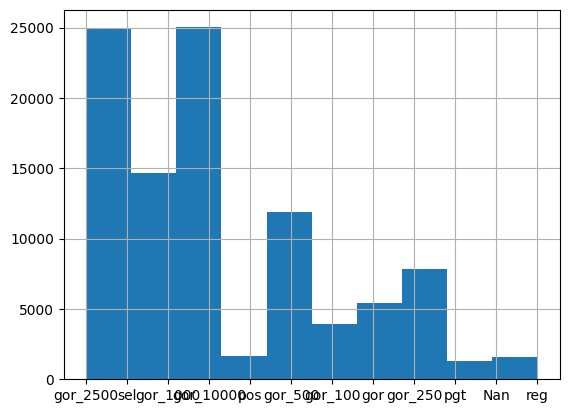

In [272]:
df_train["type_city"].hist()


In [273]:
df.describe(include='all')

,Unnamed: 0,url_car,car_make,car_model,car_gen,car_type,car_compl,ann_date,ann_id,car_price,ann_city,link_cpl,avail,year,mileage,color,eng_size,eng_power,eng_power_kw,eng_type,pow_resrv,options,transmission,drive,st_wheel,condition,count_owner,original_pts,customs,url_compl,state_mark,class_auto,door_count,seat_count,long,widht,height,clearence,v_bag,v_tank,curb_weight,gross_weight,front_brakes,rear_brakes,max_speed,acceleration,fuel_cons,fuel_brand,engine_loc1,engine_loc2,turbocharg,max_torq,cyl_count
count,131006.000000,131006,131006,131006,131006,131006,131006,131006,1.310060e+05,1.310060e+05,131006,131006,131006,131006.000000,131006.000000,131006,128674.000000,131006.000000,2332.000000,131006,2332.000000,130997,131006,131006,131006,131006,131006,130305,131006,131006,131006,130551,131006.000000,131006,131006.000000,131006.000000,131006.000000,126827,120390,126717.000000,127072.000000,112346.000000,131006,129359,123515.000000,121121.000000,123528,127965,128522,127406,128584,130386.000000,128674.000000
unique,NaN,131006,239,2147,1349,295,6797,366,NaN,NaN,3702,21123,3,NaN,NaN,16,NaN,NaN,NaN,9,NaN,3398,4,3,2,1,3,2,2,21123,25,9,NaN,51,NaN,NaN,NaN,589,3204,NaN,NaN,NaN,6,6,NaN,NaN,266,8,6,2,5,NaN,NaN
top,NaN,https://auto.ru/cars/used/sale/abarth/500/1125...,Land Rover,Cayenne,I,Внедорожник 5 дв.,1.5 CVT (147 л.с.),2024-03-06,NaN,NaN,Москва,https://auto.ru/catalog/cars/daewoo/matiz/2309...,В наличии,NaN,NaN,чёрный,NaN,NaN,NaN,Бензин,NaN,1 опция,автоматическая,передний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/daewoo/matiz/2309...,Япония,C,NaN,5,NaN,NaN,NaN,150,530,NaN,NaN,NaN,дисковые,дисковые,NaN,NaN,-,АИ-95,переднее,поперечное,нет,NaN,NaN
freq,NaN,1,3772,2096,31493,59906,1798,3255,NaN,NaN,25017,970,121777,NaN,NaN,32140,NaN,NaN,NaN,107548,NaN,36792,65502,65161,125839,131006,51933,110123,131003,970,28204,36435,NaN,90706,NaN,NaN,NaN,7844,2599,NaN,NaN,NaN,101251,77069,NaN,NaN,11440,76833,100382,86430,72664,NaN,NaN
mean,65719.937804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.124793e+09,2.728922e+06,NaN,NaN,NaN,2013.673809,132774.740516,NaN,2.164851,188.884143,361.391938,NaN,554.305746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.609392,NaN,4577.469208,1827.547692,1608.496336,NaN,NaN,61.710694,1598.612511,2122.697417,NaN,NaN,193.970910,10.514546,NaN,NaN,NaN,NaN,NaN,289.224549,4.486610
std,38148.796612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.976563e+06,6.286134e+06,NaN,NaN,NaN,8.405961,96821.414261,NaN,0.967376,120.115306,160.987048,NaN,136.091417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.665207,NaN,386.947576,111.904359,156.291984,NaN,NaN,14.483691,425.721237,505.944601,NaN,NaN,31.926805,3.895469,NaN,NaN,NaN,NaN,NaN,241.037908,1.254518
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.618293e+07,1.050000e+04,NaN,NaN,NaN,1923.000000,1.000000,NaN,0.200000,10.000000,29.000000,NaN,135.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,2488.000000,1000.000000,1000.000000,NaN,NaN,16.000000,399.000000,810.000000,NaN,NaN,60.000000,2.020000,NaN,NaN,NaN,NaN,NaN,19.000000,1.000000
25%,32751.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.124590e+09,7.170000e+05,NaN,NaN,NaN,2010.000000,52000.000000,NaN,1.600000,115.000000,245.000000,NaN,456.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,4365.000000,1769.000000,1472.000000,NaN,NaN,51.000000,1295.000000,1765.000000,NaN,NaN,175.000000,8.000000,NaN,NaN,NaN,NaN,NaN,158.000000,4.000000
50%,65502.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.125586e+09,1.470000e+06,NaN,NaN,NaN,2014.000000,125000.000000,NaN,2.000000,150.000000,393.000000,NaN,550.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,4605.000000,1825.000000,1615.000000,NaN,NaN,60.000000,1525.000000,2010.000000,NaN,NaN,190.000000,10.400000,NaN,NaN,NaN,NaN,NaN,232.000000,4.000000
75%,98253.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.125981e+09,2.700000e+06,NaN,NaN,NaN,2020.000000,194000.000000,NaN,2.500000,227.000000,440.000000,NaN,656.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,4820.000000,1

In [274]:
pd.set_option('display.max_columns', None)
df.describe(include='object')

,url_car,car_make,car_model,car_gen,car_type,car_compl,ann_date,ann_city,link_cpl,avail,color,eng_type,options,transmission,drive,st_wheel,condition,count_owner,original_pts,customs,url_compl,state_mark,class_auto,seat_count,clearence,v_bag,front_brakes,rear_brakes,fuel_cons,fuel_brand,engine_loc1,engine_loc2,turbocharg
count,131006,131006,131006,131006,131006,131006,131006,131006,131006,131006,131006,131006,130997,131006,131006,131006,131006,131006,130305,131006,131006,131006,130551,131006,126827,120390,131006,129359,123528,127965,128522,127406,128584
unique,131006,239,2147,1349,295,6797,366,3702,21123,3,16,9,3398,4,3,2,1,3,2,2,21123,25,9,51,589,3204,6,6,266,8,6,2,5
top,https://auto.ru/cars/used/sale/abarth/500/1125...,Land Rover,Cayenne,I,Внедорожник 5 дв.,1.5 CVT (147 л.с.),2024-03-06,Москва,https://auto.ru/catalog/cars/daewoo/matiz/2309...,В наличии,чёрный,Бензин,1 опция,автоматическая,передний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/daewoo/matiz/2309...,Япония,C,5,150,530,дисковые,дисковые,-,АИ-95,переднее,поперечное,нет
freq,1,3772,2096,31493,59906,1798,3255,25017,970,121777,32140,107548,36792,65502,65161,125839,131006,51933,110123,131003,970,28204,36435,90706,7844,2599,101251,77069,11440,76833,100382,86430,72664


In [275]:

# Класс для удаления столбцов из датасета
class columnDropperTransformer():
    def __init__(self,columns):
        self.columns=columns
    def transform(self,X,y=None):
        X = X.drop(self.columns,axis=1)
        return X
    def fit(self, X, y=None):
        return self     # Нет необходимости обучать

In [276]:
# Класс для обработки типа автомобиля
class columnCarTypeTransformer():
    def __init__(self,columns):
        self.columns=columns
    def transform(self,X,y=None):
        def mod_car_type(x):
            car_type_short = [
                'Внедорожник 3 дв.',
                'Внедорожник 5 дв.',
                'Внедорожник открытый',
                'Кабриолет',
                'Компактвэн',
                'Купе',
                'Лифтбек',
                'Микровэн',
                'Минивэн',
                'Пикап Двойная кабина',
                'Пикап Одинарная кабина',
                'Пикап Полуторная кабина',
                'Родстер',
                'Седан',
                'Спидстер',
                'Тарга',
                'Универсал 5 дв.',
                'Фастбек',
                'Фургон',
                'Хэтчбек 3 дв.',
                'Хэтчбек 4 дв.',
                'Хэтчбек 5 дв.'
            ]
            for car_type in car_type_short:
                if car_type in x:
                    x = car_type
            return x
        X['car_type'] = X['car_type'].apply(lambda x: mod_car_type(x) if not pd.isnull(x) else np.nan)
        return X
    def fit(self, X, y=None):
        return self     # Нет необходимости обучать

In [277]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class AgeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, year_column: str = "year", new_column: str = "car_age"):
        """
        Инициализация трансформера.

        :param year_column: Год выпуска автомобиля.
        :param new_column: Возраст автомобиля.
        """
        self.year_column = year_column
        self.new_column = new_column

    def fit(self, X, y=None):
        return self     # Нет необходимости обучать

    def transform(self, X):
        """
        Извлекает числа из начала строки для указанных столбцов.

        :param X: Входной DataFrame с годом производства.
        :return: Преобразованный DataFrame c возрастом автомобиля.
        """
        X = X.copy()
        current_year = pd.Timestamp.now().year
        X[self.new_column] = current_year - X[self.year_column]
        return X.drop(columns=[self.year_column])

In [278]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column, delta):
        """
        Инициализация трансформера.

        :param year_column: Год выпуска автомобиля.
        :param new_column: Возраст автомобиля.
        """
        self.column = column
        self.delta = delta

    def fit(self, X, y=None):
        return self     # Нет необходимости обучать

    def transform(self, X):
        """
        Извлекает числа из начала строки для указанных столбцов.

        :param X: Входной DataFrame с годом производства.
        :return: Преобразованный DataFrame c возрастом автомобиля.
        """
        X = X.copy()
        X[self.column] = np.log(X[self.column]+self.delta)
        return X

In [279]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class MultiplyDivideTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, col1: str, col2: str, operation: str = "mul"):
        """
        Инициализация трансформера.

        :param col1: Название первого столбца.
        :param col2: Название второго столбца.
        :param operation: Операция ('multiply' или 'divide').
        :param new_column: Название нового столбца.
        """
        self.col1 = col1
        self.col2 = col2
        self.operation = operation
        self.new_column = f'{col1}_{operation}_{col2}'

    def fit(self, X, y=None):
        return self  # Нет необходимости в обучении

    def transform(self, X):
        """
        Выполняет операцию умножения или деления и создаёт новый столбец.

        :param X: Входной DataFrame.
        :return: Преобразованный DataFrame с новым столбцом.
        """
        X = X.copy()
        if self.operation == "mul":
            X[self.new_column] = X[self.col1] * X[self.col2]
        elif self.operation == "div":
            X[self.new_column] = X[self.col1] / (X[self.col2] + 1)
        else:
            raise ValueError("Операция должна быть 'mul' или 'div'")
        return X


In [280]:
# Создание класса-трансформера для заполнения пропусков медианой по группам
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Класс-трансформер для заполнения пропусков медианой по группам
class GroupMedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_cols, target_col):
        """
        Инициализация трансформера.
        
        :param group_cols: Список колонок для группировки.
        :param target_col: Колонка с пропусками для заполнения.
        """
        self.group_cols = group_cols
        self.target_col = target_col
        self.group_medians_ = None

    def fit(self, X, y=None):
        # Рассчитываем медианы по комбинации значений в group_cols
        self.group_medians_ = (
            X.groupby(self.group_cols)[self.target_col]
            .median()
            .reset_index()
            .rename(columns={self.target_col: "median_value"})
        )
        return self

    def transform(self, X):
        X = X.copy()
        # Объединяем с рассчитанными медианами по ключевым столбцам
        X = X.merge(self.group_medians_, on=self.group_cols, how="left")
        # Заполняем пропуски в целевой колонке
        X[self.target_col] = X[self.target_col].fillna(X["median_value"])
        # Удаляем временную колонку с медианой
        X.drop(columns=["median_value"], inplace=True)
        return X

In [281]:
# Создание класса-трансформера для заполнения пропусков модой по группам
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Класс-трансформер для заполнения пропусков модой по группам
class GroupModeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_cols, target_col):
        """
        Инициализация трансформера.

        :param group_cols: Список колонок для группировки.
        :param target_col: Колонка с пропусками для заполнения.
        """
        self.group_cols = group_cols
        self.target_col = target_col
        self.group_modes_ = None

    def fit(self, X, y=None):
        # Рассчитываем моды по комбинации значений в group_cols
        def safe_mode(series):
            if series.empty:
                return np.nan
            mode = series.mode()
            return mode.iloc[0] if not mode.empty else np.nan

        self.group_modes_ = (
            X.groupby(self.group_cols)[self.target_col]
            .agg(safe_mode)
            .reset_index()
            .rename(columns={self.target_col: "mode_value"})
        )
        return self

    def transform(self, X):
        X = X.copy()
        # Объединяем с рассчитанными модами по ключевым столбцам
        X = X.merge(self.group_modes_, on=self.group_cols, how="left")
        # Заполняем пропуски в целевой колонке
        X[self.target_col] = X[self.target_col].fillna(X["mode_value"])
        # Удаляем временную колонку с модой
        X.drop(columns=["mode_value"], inplace=True)
        return X

In [282]:
# Создание класса-трансформера для замены пропусков в столбце на основе условий из другого столбца
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Класс-трансформер для замены пропусков в столбце на основе условий из другого столбца
class ConditionalValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, condition_col, target_col, fill_mapping):
        """
        Инициализация трансформера.

        :param condition_col: Колонка с условиями.
        :param target_col: Колонка, в которой будут заменяться пропуски.
        :param fill_mapping: Словарь, где ключ - значение из condition_col, а значение - значение для замены пропусков в target_col.
        """
        self.condition_col = condition_col
        self.target_col = target_col
        self.fill_mapping = fill_mapping

    def fit(self, X, y=None):
        return self  # Нет необходимости обучать

    def transform(self, X):
        X = X.copy()
        for condition_value, fill_value in self.fill_mapping.items():
            mask = (X[self.condition_col] == condition_value) & (X[self.target_col].isna())
            X.loc[mask, self.target_col] = fill_value
        return X

In [283]:
# Создание класса-трансформера для преобразования строк, начинающихся с числа, в число
import pandas as pd
import numpy as np

# Класс-трансформер для преобразования строк, начинающихся с числа, в число
class NumberExtractorTransformer():
    def __init__(self, columns):
        """
        Инициализация трансформера.

        :param columns: Список названий столбцов, для которых нужно извлекать числа.
        """
        self.columns = columns

    def transform(self, X, y=None):
        """
        Извлекает числа из начала строки для указанных столбцов.

        :param X: Входной DataFrame.
        :param y: Не используется, добавлен для совместимости с API sklearn.
        :return: Преобразованный DataFrame.
        """
        X = X.copy()
        for column in self.columns:
            X[column] = (
                X[column]
                .astype(str)             # Преобразование в строку
                .str.extract(r'^(\d+)')  # Извлечение первого числа в начале строки
                .astype(float)           # Преобразование к числовому типу
            )
        return X

    def fit(self, X, y=None):
        return self  # Нет необходимости обучать

In [284]:
# Класс для удаления дубликатов
class DropDuplicate:
    def __init__(self, columns_to_exclude=None):
        """
        Класс для удаления дубликатов на основе выбранных столбцов.

        :param columns_to_exclude: Список столбцов, которые нужно исключить из проверки на дубликаты.
        """
        self.columns_to_exclude = columns_to_exclude or []

    def transform(self, X, y=None):
        """
        Удаляет дубликаты из DataFrame на основе заданных столбцов.

        :param X: Входной DataFrame.
        :param y: Не используется, добавлен для совместимости с API sklearn.
        :return: DataFrame без дубликатов.
        """
        X = X.copy()
        # Определение столбцов для проверки на дубликаты
        column_features = [col for col in X.columns if col not in self.columns_to_exclude]
        # Удаление дубликатов
        X = X.drop_duplicates(subset=column_features, keep='first').reset_index(drop=True)
        return X

    def fit(self, X, y=None):
        return self  # Нет необходимости обучать

In [285]:
# Класс для обновления индекса
class resetIndex():

    def transform(self,X,y=None):
        """
        Класс для обновления индекса.
        
        :param X: Входной DataFrame.
        :param y: Не используется, добавлен для совместимости с API sklearn.
        :return: DataFrame с обновленным индексом.
        """
        X = X.reset_index(drop=True)
        return X
    
    def fit(self, X, y=None):
        return self  # Нет необходимости обучать

In [286]:
# Пока пустой пайплайн для обработки полей
pipelines = []

In [287]:
# Добавляем пайплайн для удаления полей, преобразования 'car_type' и 'count_owner', 
# 'seat_count', 'clearence', 'v_bag', 'fuel_cons'
drop_columns = ['Unnamed: 0', 
                'url_car', 
                'ann_id', 
                'ann_date', 
                'ann_city', 
                #'avail', 
                #'original_pts', 
                #'customs', 
                'link_cpl', 
                'eng_power_kw', 
                'pow_resrv', 
                'options', 
                'condition', 
                'url_compl', 
                #'gross_weight',
                'region',
                #'type_city', 
                'okr_ocatd', 
                'okr_code',
                'Count'
                ]

pipelines.append(("column_dropper", columnDropperTransformer(drop_columns)))
pipelines.append(("car_type_transformer", columnCarTypeTransformer('car_type')))
pipelines.append(("count_owner_transformer", 
                  NumberExtractorTransformer(columns=['count_owner', 
                                                      'seat_count', 
                                                      'clearence', 
                                                      'v_bag', 
                                                      'fuel_cons'])))
pipelines.append(("age_transformer", AgeTransformer()))

In [288]:
# Добавляем пайплайн для замены пропусков в классе автомобиля ("class_auto")
pipelines.append((f'class_auto_transformer_car_type', ConditionalValueImputer(
    condition_col='car_type',
    target_col='class_auto',
    fill_mapping={
        'Фургон': 'M',
        'Лимузин': 'F',
        }
    )),
    )

strategy = [['car_make', 'car_model', 'car_gen', 'eng_type'], 
            ['car_make', 'car_model', 'car_gen'], 
            ['car_make', 'car_model', 'eng_type'],
            ['car_make', 'car_model'],
            ['car_type', 'eng_type'], 
            ['car_type']
            ]

target_columns = ['class_auto']

for target_column in target_columns:
    for columns in strategy:
        pipelines.append(((f'group_mean_imputer_{target_column}_{columns}', 
                           GroupModeImputer(group_cols=columns, target_col=target_column))))

In [289]:
# Добавляем пайплайн для замены пропусков в числовых полях для электрокаров
target_columns = ['eng_size', 'v_tank', 'fuel_cons', 'cyl_count']

for target_column in target_columns:
    pipelines.append((f'eng_type_elektro_transformer_{target_column}', ConditionalValueImputer(
        condition_col='eng_type',
        target_col=target_column,
        fill_mapping={
            'Электро': 0,  # Для электрокаров заполняем 0
            }
        )),
    )
    
# Добавляем пайплайн для замены пропусков в текстовых полях для электрокаров
target_columns = ['fuel_brand', 'engine_loc1', 'engine_loc2', 'turbocharg']

for target_column in target_columns:
    pipelines.append((f'eng_type_elektro_transformer_{target_column}', ConditionalValueImputer(
        condition_col='eng_type',
        target_col=target_column,
        fill_mapping={
            'Электро': 'Nan',  # Для электрокаров заполняем 'Nan'
            }
        )),
    )

In [290]:
# Добавляем пайплайн для замены пропусков в числовых полях медианой
strategy = [['car_make', 'car_model', 'car_gen', 'eng_type'], 
            ['car_make', 'car_model', 'car_gen'], 
            ['car_make', 'car_model', 'eng_type'],
            ['car_make', 'car_model'],
            ['car_type', 'class_auto', 'eng_type'], 
            ['car_type', 'class_auto'],
            ['car_type', 'eng_type'], 
            ['car_type'],
            ['class_auto', 'eng_type'],
            ['class_auto']
            ]

target_columns = ['clearence', 
                  'v_bag', 
                  'v_tank', 
                  'curb_weight', 
                  'gross_weight',
                  'max_speed', 
                  'acceleration', 
                  'fuel_cons', 
                  'max_torq']

for target_column in target_columns:
    for columns in strategy:
        pipelines.append(((f'group_median_imputer_{target_column}_{columns}', GroupMedianImputer(group_cols=columns, target_col=target_column))))


In [291]:
# Добавляем пайплайн для замены пропусков в категориальных полях модой
strategy = [['car_make', 'car_model', 'car_gen', 'eng_type'], 
            ['car_make', 'car_model', 'car_gen'], 
            ['car_make', 'car_model', 'eng_type'],
            ['car_make', 'car_model'],
            ['car_type', 'class_auto', 'eng_type'], 
            ['car_type', 'class_auto'],
            ['car_type', 'eng_type'], 
            ['car_type'],
            ['class_auto', 'eng_type'],
            ['class_auto']
            ]

target_columns = ['rear_brakes',
                  'max_speed',
                  'fuel_brand',
                  'engine_loc1',
                  'engine_loc2',
                  'turbocharg',
                  'original_pts']

for target_column in target_columns:
    for columns in strategy:
        pipelines.append(((f'group_moda_imputer_{target_column}_{columns}', 
                           GroupModeImputer(group_cols=columns, target_col=target_column))))


In [292]:
df_train.head(5)

,Unnamed: 0,url_car,car_make,car_model,car_gen,car_type,car_compl,ann_date,ann_id,car_price,ann_city,link_cpl,avail,year,mileage,color,eng_size,eng_power,eng_power_kw,eng_type,pow_resrv,options,transmission,drive,st_wheel,condition,count_owner,original_pts,customs,url_compl,state_mark,class_auto,door_count,seat_count,long,widht,height,clearence,v_bag,v_tank,curb_weight,gross_weight,front_brakes,rear_brakes,max_speed,acceleration,fuel_cons,fuel_brand,engine_loc1,engine_loc2,turbocharg,max_torq,cyl_count,region,type_city,okr_ocatd,okr_code,Count
0,76887,https://auto.ru/cars/used/sale/skoda/yeti/1125...,Skoda,Yeti,I,Внедорожник 5 дв.,1.2 AMT (105 л.с.),2024-11-12,1125913409,630000,Ростов-на-Дону,https://auto.ru/catalog/cars/skoda/yeti/603890...,В наличии,2010,310000,белый,1.2,105,NaN,Бензин,NaN,1 опция,роботизированная,передний,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,https://auto.ru/catalog/cars/skoda/yeti/603890...,Чехия,B,5,5,4223,1793,1691,180,405/1760,55.0,1345.0,1890.0,дисковые,дисковые,173.0,12.0,5.9,АИ-95,переднее,поперечное,турбонаддув,175.0,4.0,Ростовская,gor_2500,6.0,G,1142.0
1,39421,https://auto.ru/cars/used/sale/land_rover/defe...,Land Rover,Defender,II,Внедорожник 5 дв. 110,110 2.0d AT (200 л.с.) 4WD,2024-10-05,1125180969,6450000,Минск,https://auto.ru/catalog/cars/land_rover/defend...,В наличии,2020,30000,серый,2.0,200,NaN,Дизель,NaN,SE,автоматическая,полный,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/land_rover/defend...,Великобритания,J,5,"5, 7",5018,1996,1967,218-291,1075/2380,89.0,2323.0,3150.0,дисковые,дисковые,175.0,10.3,7.2,ДТ,переднее,продольное,турбонаддув,430.0,4.0,Красноярский,sel,0.0,C,NaN
2,47603,https://auto.ru/cars/used/sale/mazda/6/1125954...,Mazda,6,III (GJ) Рестайлинг 2,Седан,2.5 AT (231 л.с.),2024-11-14,1125954334,4700000,Пенза,https://auto.ru/catalog/cars/mazda/6/21357560/...,В наличии,2021,14000,серый,2.5,231,NaN,Бензин,NaN,Executive Plus (Пакет 8),автоматическая,передний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,https://auto.ru/catalog/cars/mazda/6/21357560/...,Япония,D,4,5,4870,1840,1450,165,429,62.0,1578.0,2095.0,дисковые,дисковые,239.0,7.0,5.9,АИ-95,переднее,поперечное,турбонаддув,420.0,4.0,Пензенская,gor_1000,5.0,F,501.0
3,117768,https://auto.ru/cars/used/sale/subaru/impreza/...,Subaru,Impreza,III,Хэтчбек 5 дв.,1.5 AT (107 л.с.) 4WD,2024-02-28,1127237671,620000,Москва,https://auto.ru/catalog/cars/subaru/impreza/23...,В наличии,2007,130000,коричневый,1.5,107,NaN,Бензин,NaN,49 опций,автоматическая,полный,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,https://auto.ru/catalog/cars/subaru/impreza/23...,Япония,C,5,5,4465,1695,1485,155.0,356.0,50.0,1325.0,1765.0,Дисковые,Дисковые,167.0,15.1,6.2,АИ-95,Переднее,продольное,нет,142.0,4.0,Москва,gor_10000,4.0,H,13010.0
4,38813,https://auto.ru/cars/used/sale/land_rover/disc...,Land Rover,Discovery Sport,I,Внедорожник 5 дв.,2.0d AT (150 л.с.) 4WD,2024-05-26,1123517822,2575000,Газопровод,https://auto.ru/catalog/cars/land_rover/discov...,В наличии,2018,99600,белый,2.0,150,NaN,Дизель,NaN,SE,автоматическая,полный,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,https://auto.ru/catalog/cars/land_rover/discov...,Великобритания,D,5,"5, 7",4599,2069,1724,212,981/1698,65.0,1775.0,NaN,дисковые,дисковые,180.0,10.3,4.7,ДТ,переднее,поперечное,турбонаддув,380.0,4.0,Калужская,pos,2.0,E,NaN


In [293]:
# Добавляем пайплайн для добавления multiple и divide признаков
columns = [
    #['mileage', 'car_age', 'div'],
    #['eng_power', 'curb_weight', 'div'],
    ['widht', 'long', 'div'],
    ['widht', 'height', 'div'],
    ['widht', 'clearence', 'div'],
    ['eng_power', 'acceleration', 'div'],
    ['eng_power', 'max_speed', 'div'],
    ]


for column in columns:
    pipelines.append(((f'mul_div_transformer_{column[0]}_{column[2]}_{column[1]}', 
                        MultiplyDivideTransformer(col1=column[0], col2=column[1], operation=column[2]))))

In [294]:
target_column = "car_price"
delta_y = 2900000
pipelines.append(((f'log_transformer_{target_column}', LogTransformer(target_column, delta_y))))

target_column = "mileage"
pipelines.append(((f'log_transformer_{target_column}', LogTransformer(target_column, 7500))))

target_column = "eng_power"
pipelines.append(((f'log_transformer_{target_column}', LogTransformer(target_column, 5))))

target_column = "max_speed"
pipelines.append(((f'log_transformer_{target_column}', LogTransformer(target_column, 1.75))))

target_column = "acceleration"
pipelines.append(((f'log_transformer_{target_column}', LogTransformer(target_column, 1.75))))

target_column = "cyl_count"
pipelines.append(((f'log_transformer_{target_column}', LogTransformer(target_column, 2.25))))

target_column = "long"
pipelines.append(((f'log_transformer_{target_column}', LogTransformer(target_column, 2.25))))

target_column = "car_age"
pipelines.append(((f'log_transformer_{target_column}', LogTransformer(target_column, 27))))

target_column = "eng_size"
pipelines.append(((f'log_transformer_{target_column}', LogTransformer(target_column, 10))))

target_column = "max_torq"
pipelines.append(((f'log_transformer_{target_column}', LogTransformer(target_column, 100000))))

target_column = "door_count"
pipelines.append(((f'log_transformer_{target_column}', LogTransformer(target_column, 1.62))))

target_column = "clearence"
pipelines.append(((f'log_transformer_{target_column}', LogTransformer(target_column, 25000))))

In [295]:
target_columns = [
    #'v_tank',
    #'cyl_count'
    #'count_owner',
    #'widht',
    #'height',
    ]

for target_column in target_columns:
    pipelines.append(((f'sqrt_transformer_{target_column}', LogTransformer(target_column, 100000))))

In [296]:
# Добавляем пайплайн для удаления полей, преобразования car_type и count_owner
drop_columns = ['car_model', 'car_gen', 'car_compl']

pipelines.append(("column_dropper_transformer", columnDropperTransformer(drop_columns)))
pipelines.append(("drop_duplicate", DropDuplicate()))
pipelines.append(("reset_index", resetIndex()))

In [297]:
# Создаем пайплайн
pipeline = Pipeline(steps=pipelines)

# Обучение Pipeline
transformed_train = pipeline.fit_transform(df_train)

# Преобразование тестовых данных
transformed_test = pipeline.transform(df_test)

In [298]:
transformed_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98166 entries, 0 to 98165
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   car_make                    98166 non-null  object 
 1   car_type                    98166 non-null  object 
 2   car_price                   98166 non-null  float64
 3   avail                       98166 non-null  object 
 4   mileage                     98166 non-null  float64
 5   color                       98166 non-null  object 
 6   eng_size                    98166 non-null  float64
 7   eng_power                   98166 non-null  float64
 8   eng_type                    98166 non-null  object 
 9   transmission                98166 non-null  object 
 10  drive                       98166 non-null  object 
 11  st_wheel                    98166 non-null  object 
 12  count_owner                 98166 non-null  float64
 13  original_pts                981

In [299]:
# Преобразуем и разделяем признаки и таргет
X_train = transformed_train.copy()
y_train = transformed_train['car_price']
X_test = transformed_test.copy()
y_test = transformed_test['car_price']
X_train = X_train.drop(['car_price'], axis=1)
X_test = X_test.drop(['car_price'], axis=1)

In [300]:
# Преобразование категориальных признаков в Pandas category
for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [301]:
'''import optuna
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

def objective(trial):
    """Функция для оптимизации гиперпараметров с помощью optuna."""
    
    # Пространство поиска гиперпараметров
    params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'metric': 'l2',  # LightGBM не поддерживает 'r2', используем MSE
        'n_jobs': -1,
        'seed': 13,
        'verbosity': -1,
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10.0, log=True),
        'max_bin': trial.suggest_int('max_bin', 50, 500),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0)
    }
    
    scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=13)
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Если есть категориальные признаки
        cat_features = [i for i, col in enumerate(X_train.columns) if X_train[col].dtype == "object"]
        
        lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=cat_features)
        lgb_eval = lgb.Dataset(X_val, y_val, categorical_feature=cat_features)

        lgb_model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_eval],  # Используем только валидацию
            valid_names=['val'],
        )
        
        y_pred = lgb_model.predict(X_val)
        score_fold = r2_score(y_val, y_pred)  # R² на валидации
        scores.append(score_fold)
    
    return np.mean(scores)

# Запуск optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Вывод лучших параметров
print("Best params:", study.best_params)
print("Best R2:", study.best_value)
'''

'import optuna\nimport lightgbm as lgb\nimport numpy as np\nimport pandas as pd\nfrom sklearn.metrics import r2_score\nfrom sklearn.model_selection import KFold\n\ndef objective(trial):\n    """Функция для оптимизации гиперпараметров с помощью optuna."""\n    \n    # Пространство поиска гиперпараметров\n    params = {\n        \'objective\': \'regression\',\n        \'boosting_type\': \'gbdt\',\n        \'metric\': \'l2\',  # LightGBM не поддерживает \'r2\', используем MSE\n        \'n_jobs\': -1,\n        \'seed\': 13,\n        \'verbosity\': -1,\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 100, 2000),\n        \'early_stopping_rounds\': trial.suggest_int(\'early_stopping_rounds\', 50, 200),\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.005, 0.2, log=True),\n        \'num_leaves\': trial.suggest_int(\'num_leaves\', 20, 300),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 15),\n        \'min_child_samples\': trial.suggest_int(\'min_

Best params: {'n_estimators': 1627, 'early_stopping_rounds': 130, 'learning_rate': 0.016435169762442435, 'num_leaves': 191, 'max_depth': 10, 'min_child_samples': 12, 'min_child_weight': 0.005440087406276805, 'subsample': 0.9227254082719458, 'colsample_bytree': 0.45729891926026756, 'reg_alpha': 0.003722831129307499, 'reg_lambda': 6.691003116736897e-05, 'max_bin': 353, 'scale_pos_weight': 6.822004856040776}
Best R2: 0.9717134712501878

In [307]:
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
import numpy as np


params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'l2',  # LightGBM не поддерживает 'r2', используем MSE
    'n_jobs': -1,
    'seed': 13,
    'verbosity': -1,
    'n_estimators': 1627,
    'learning_rate': 0.016435169762442435, 
    'num_leaves': 191, 
    'max_depth': 10, 
    'min_child_samples': 12, 
    'min_child_weight': 0.005440087406276805, 
    'subsample': 0.9227254082719458, 
    'colsample_bytree': 0.45729891926026756, 
    'reg_alpha': 0.003722831129307499, 
    'reg_lambda': 6.691003116736897e-05, 
    'max_bin': 353, 
    'scale_pos_weight': 6.822004856040776
}

# Создаём модель отдельно и передаём категории через set_params
lgbm = LGBMRegressor(**params, random_state=42)
#lgbm.set_params(categorical_feature=cat_indices)

# Создаём пайплайн
pipeline_lgbm = Pipeline(steps=[
    ('regressor', lgbm)
])

model_lgbm = pipeline_lgbm.fit(X_train, y_train)

y_pred = model_lgbm.predict(X_test)
y_pred_train = model_lgbm.predict(X_train)


In [310]:
'''import joblib

# Сохранение модели
joblib.dump(model_lgbm, 'lgbm_pipeline_.pkl')

# Загрузка модели
loaded_model = joblib.load('lgbm_pipeline_.pkl')

# Проверка предсказаний
y_pred = loaded_model.predict(X_test)'''

In [303]:
# Функция вывода основных характеристик модели (ориентируемся прежде всего на R^2)
def print_r2_mse_exp(y_train, y_pred_train, y_test, y_pred):
    '''
    Функция принимает на вход признаки и таргет для тренировочных
    и тестовых данных, модель и выводит на экран 
    значения MSE, R^2 для трейна и теста для указанных параметров
    '''
    print('*'*20)
    print(f'Значение MAE для трейна:  {MAE(np.exp(y_train) - delta_y, np.exp(y_pred_train) - delta_y)}')
    print(f'Значение MAE для теста:   {MAE(np.exp(y_test) - delta_y, np.exp(y_pred) - delta_y)}')
    print('*'*20)
    print(f'Значение MSE для трейна:  {MSE(np.exp(y_train) - delta_y, np.exp(y_pred_train) - delta_y)}')
    print(f'Значение MSE для теста:   {MSE(np.exp(y_test) - delta_y, np.exp(y_pred) - delta_y)}')
    print('*'*20)
    print(f'Значение R^2 для трейна:  {r2_score(np.exp(y_train) - delta_y, np.exp(y_pred_train) - delta_y)}')
    print(f'Значение R^2 для теста:   {r2_score(np.exp(y_test) - delta_y, np.exp(y_pred) - delta_y)}')

In [311]:
print_r2_mse_exp(y_train, y_pred_train, y_test, y_pred) # Выводим результаты, довольны собой

********************
Значение MAE для трейна:  217884.09450490336
Значение MAE для теста:   315298.71649147646
********************
Значение MSE для трейна:  522908576983.93
Значение MSE для теста:   1875556231847.2312
********************
Значение R^2 для трейна:  0.9870377786834723
Значение R^2 для теста:   0.9493546359021411
